# SHAP for 4-Week Model

Gaylen Fronk  
June 1, 2024

In [ ]:
study <- "match"
version <- "v5"
y_col_name <- "pp_hybrid_wk4_outcome"

In [ ]:
#| message: false
#| warning: false

# packages for script
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [ ]:
#| message: false
#| warning: false

# handle conflicts
options(conflicts.policy = "depends.ok")

In [ ]:
# absolute paths
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_data <- str_c("P:/studydata/match/chtc/", y_col_name)},
        
        # IOS paths
        Darwin = {
          path_data <- str_c("/Volumes/private/studydata/match/chtc/", y_col_name)},
        
        # Linux paths
        Linux = {
          path_data <- str_c("~/mnt/private/studydata/match/chtc/", y_col_name)}
)

In [ ]:
# chunk defaults

options(tibble.width = Inf)
options(tibble.print_max = Inf)

## Read in data

In [ ]:
local <- read_csv(file.path(path_data, str_c("shap_loocv_", version), 
                            "output", "batch_results.csv"),
                  col_types = "cddd")

glimpse(local)

Rows: 1,273,830
Columns: 4
$ variable_name  <chr> "age_1st_cig", "age_daily_smoker", "age_ehr", "alc_bing…
$ variable_value <dbl> 0.18140, -0.56780, 0.57420, 0.70530, 1.41800, -0.02156,…
$ contribution   <dbl> 0.000000e+00, -9.205713e-05, 0.000000e+00, 0.000000e+00…
$ subid          <dbl> 51514, 51514, 51514, 51514, 51514, 51514, 51514, 51514,…

This is already local SHAP values because we have one observation per subid per variable.

## Get global Shapley values

In [ ]:
global <- local |> 
  group_by(variable_name) |> 
  summarize(abs_shap = abs(mean(contribution))) |> 
  arrange(desc(abs_shap))

glimpse(global)

Rows: 1,183
Columns: 2
$ variable_name <chr> "treatment_combo_nrt_x_race_ehr_black_african_american",…
$ abs_shap      <dbl> 0.0025035357, 0.0020666109, 0.0019589872, 0.0017329089, …

Delineate treatment interactions

In [ ]:
global <- global |> 
  mutate(tx_int = if_else(str_detect(variable_name, "treatment_"), "Interaction", "Main Effect"))

local <- local |> 
  mutate(tx_int = if_else(str_detect(variable_name, "treatment_"), "Interaction", "Main Effect"))

## Make global figures

Overall

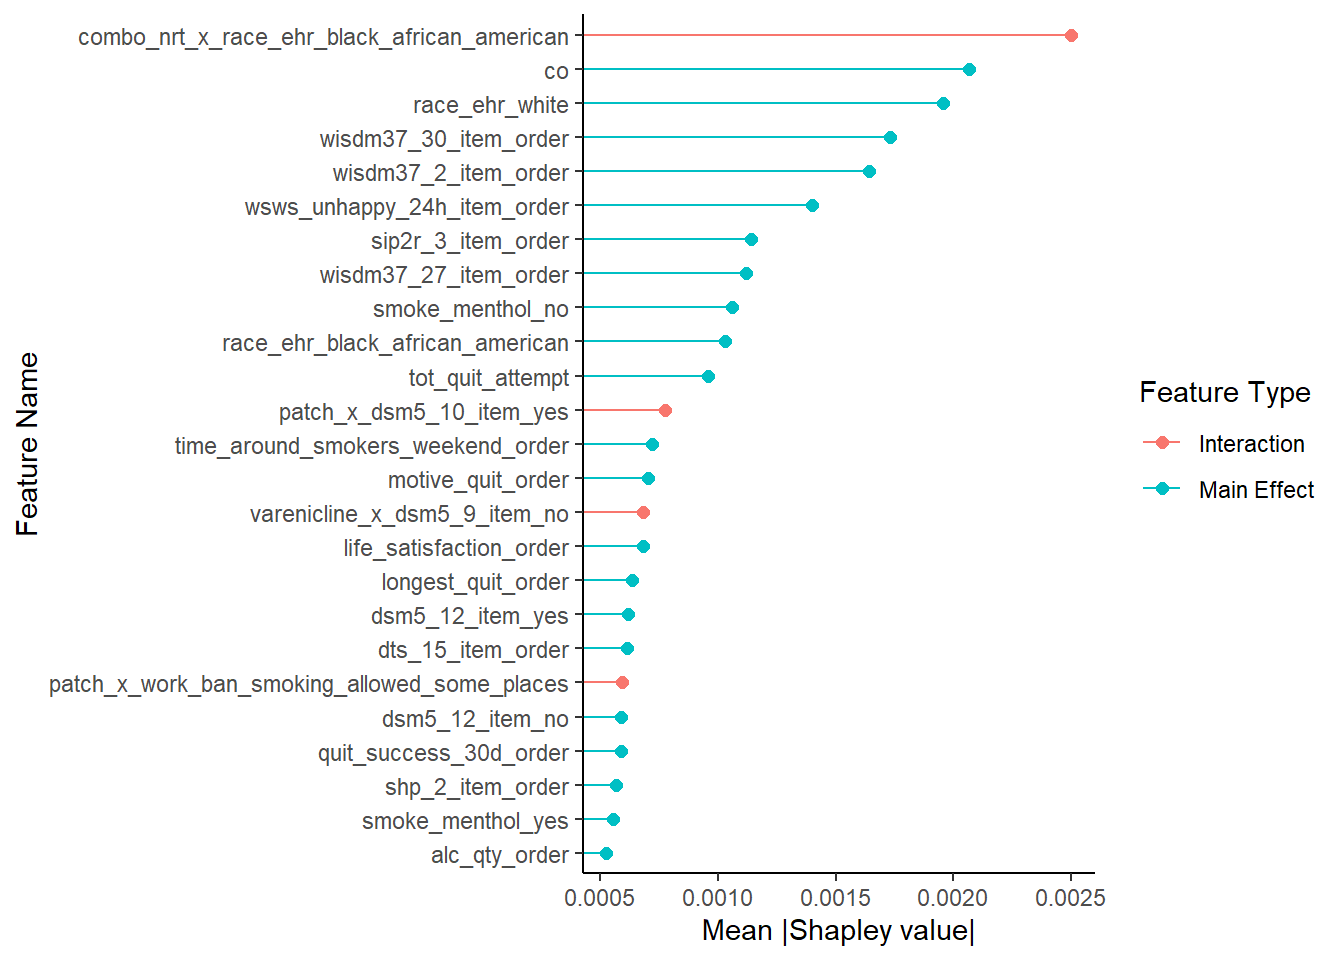

In [ ]:
#| label: fig-shap-global

fig_shap_global <- global |> 
  arrange(desc(abs_shap)) |> 
  slice(1:25) |> 
  arrange(abs_shap) |> 
  mutate(variable_name = str_replace(variable_name, "treatment_", "")) |> 
  mutate(variable_name = fct_inorder(variable_name)) |> 
  ggplot(mapping = aes(x = variable_name, y = abs_shap, color = tx_int)) +
  geom_point(size = 2) +
  geom_segment(aes(x = variable_name, y = abs_shap, xend = variable_name),
               yend = 0) +
  labs(
    x = "Feature Name",
    y = "Mean |Shapley value|",
    color = "Feature Type"
  ) +
  coord_flip()

fig_shap_global

Global Shapley values among treatment interactions

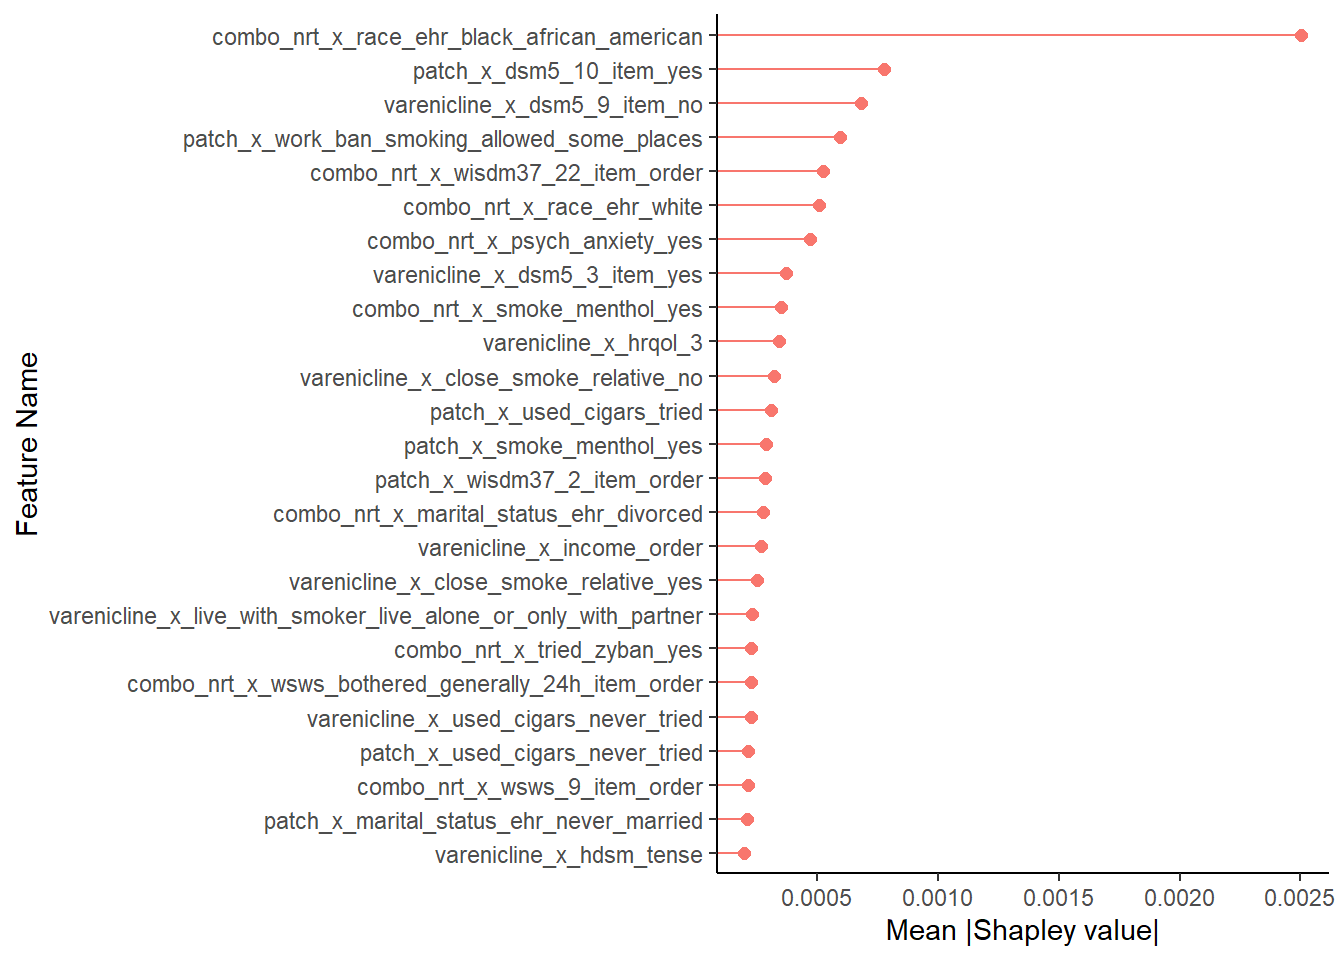

In [ ]:
#| label: fig-shap-global-tx

fig_shap_global_tx <- global |> 
  filter(tx_int == "Interaction") |> 
  arrange(desc(abs_shap)) |> 
  slice(1:25) |> 
  arrange(abs_shap) |> 
  mutate(variable_name = str_replace(variable_name, "treatment_", "")) |> 
  mutate(variable_name = fct_inorder(variable_name)) |> 
  ggplot(mapping = aes(x = variable_name, y = abs_shap, color = tx_int)) +
  geom_point(size = 2) +
  geom_segment(aes(x = variable_name, y = abs_shap, xend = variable_name),
               yend = 0) +
  labs(
    x = "Feature Name",
    y = "Mean |Shapley value|"
  ) +
  coord_flip() +
  theme(legend.position = "none")

fig_shap_global_tx

## Make Sina plots (local)

Overall

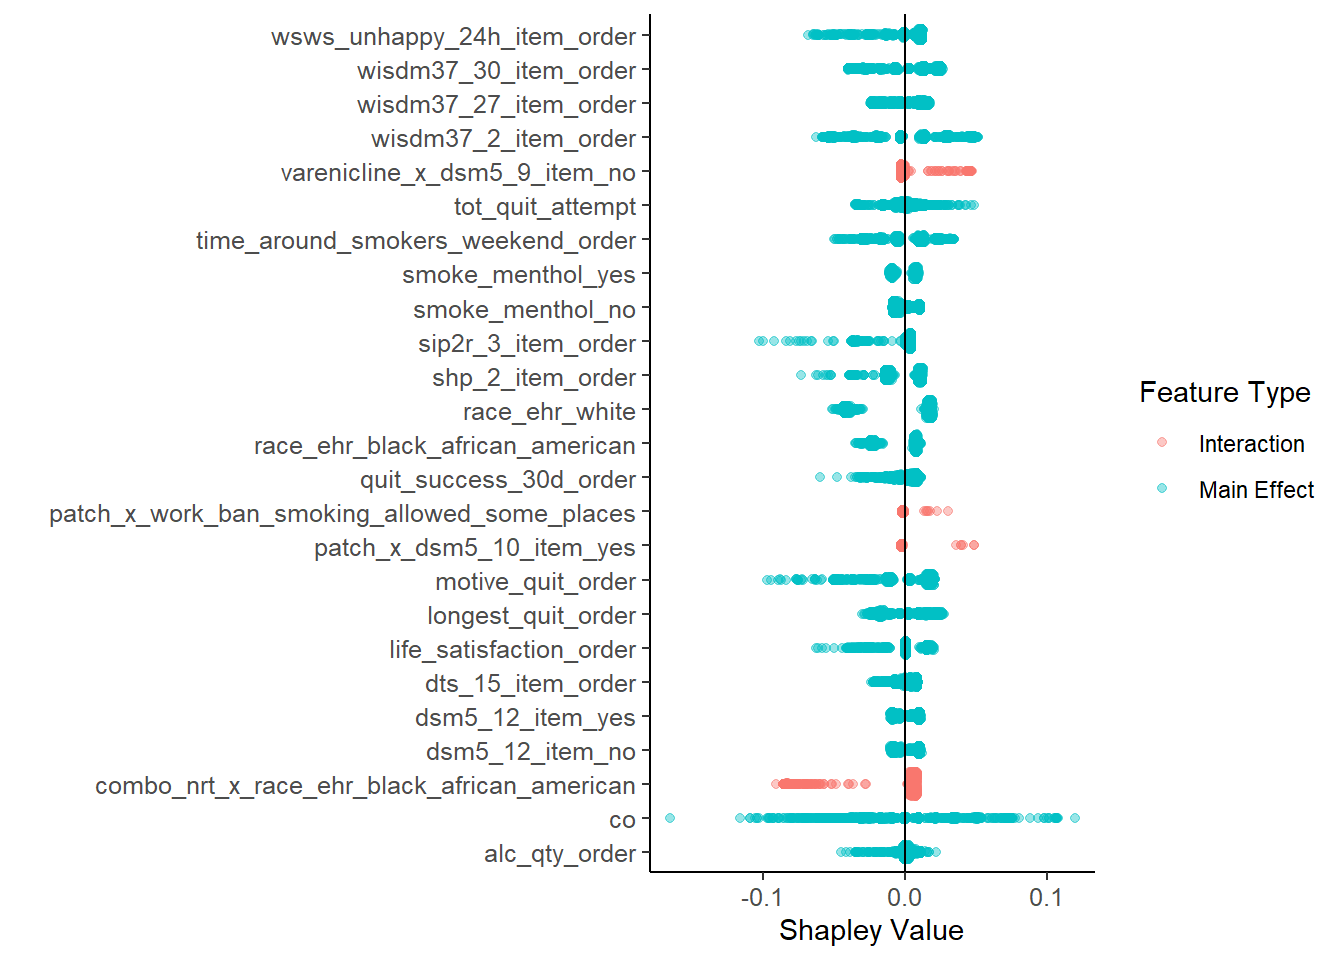

In [ ]:
# get levels in order from global plot
levels_all <- global |>
  arrange(desc(abs_shap)) |> 
  slice(1:25) |> 
  pull(variable_name)

fig_shap_local_all <- local |>
  filter(variable_name %in% levels_all) |>
  mutate(variable_name = factor(variable_name, levels = levels_all)) |>
  mutate(variable_name = str_replace(variable_name, "treatment_", "")) |> 
  ggplot(mapping = aes(x = variable_name, y = contribution,
                       color = tx_int)) +
  ggforce::geom_sina(method = "counts", maxwidth = 0.7, alpha = 0.4) +
  geom_hline(yintercept = 0) +
  #scale_y_continuous(limits = c(-2, 5), breaks = seq(-2, 5)) +
  labs(
    x = "",
    y = "Shapley Value",
    color = "Feature Type"
  ) +
  theme(axis.text = element_text(size = 9.5)) +
  coord_flip()

fig_shap_local_all

Local Shapley values among treatment interactions

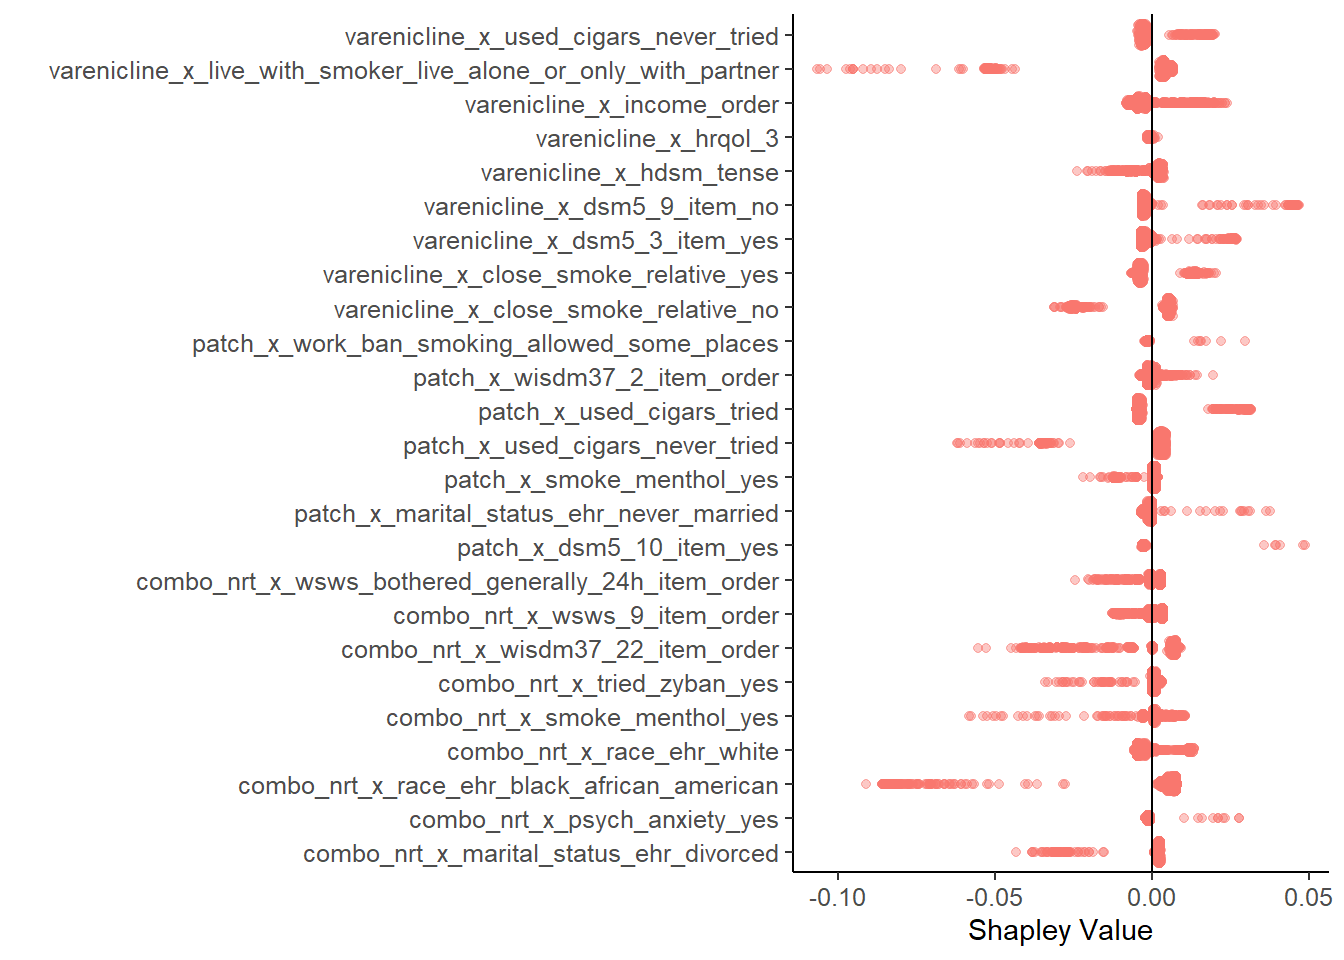

In [ ]:
# get levels in order from global plot
levels_tx <- global |>
  filter(tx_int == "Interaction") |> 
  arrange(desc(abs_shap)) |> 
  slice(1:25) |> 
  pull(variable_name)

fig_shap_local_tx <- local |> 
  filter(tx_int == "Interaction") |> 
  filter(variable_name %in% levels_tx) |>
  mutate(variable_name = factor(variable_name, levels = levels_tx)) |>
  mutate(variable_name = str_replace(variable_name, "treatment_", "")) |> 
  ggplot(mapping = aes(x = variable_name, y = contribution,
                       color = tx_int)) +
  ggforce::geom_sina(method = "counts", maxwidth = 0.7, alpha = 0.4) +
  geom_hline(yintercept = 0) +
  #scale_y_continuous(limits = c(-2, 5), breaks = seq(-2, 5)) +
  labs(
    x = "",
    y = "Shapley Value",
  ) +
  theme(axis.text = element_text(size = 9.5),
        legend.position = "none") +
  coord_flip()

fig_shap_local_tx

from ema

In [ ]:
#
# # order features to match global plot
# shap_levels <- shap_global_all |>
#   mutate(variable_grp = reorder(variable_grp, mean_value, sum)) |>
#   pull(variable_grp) |>
#   levels()
#

## Combine

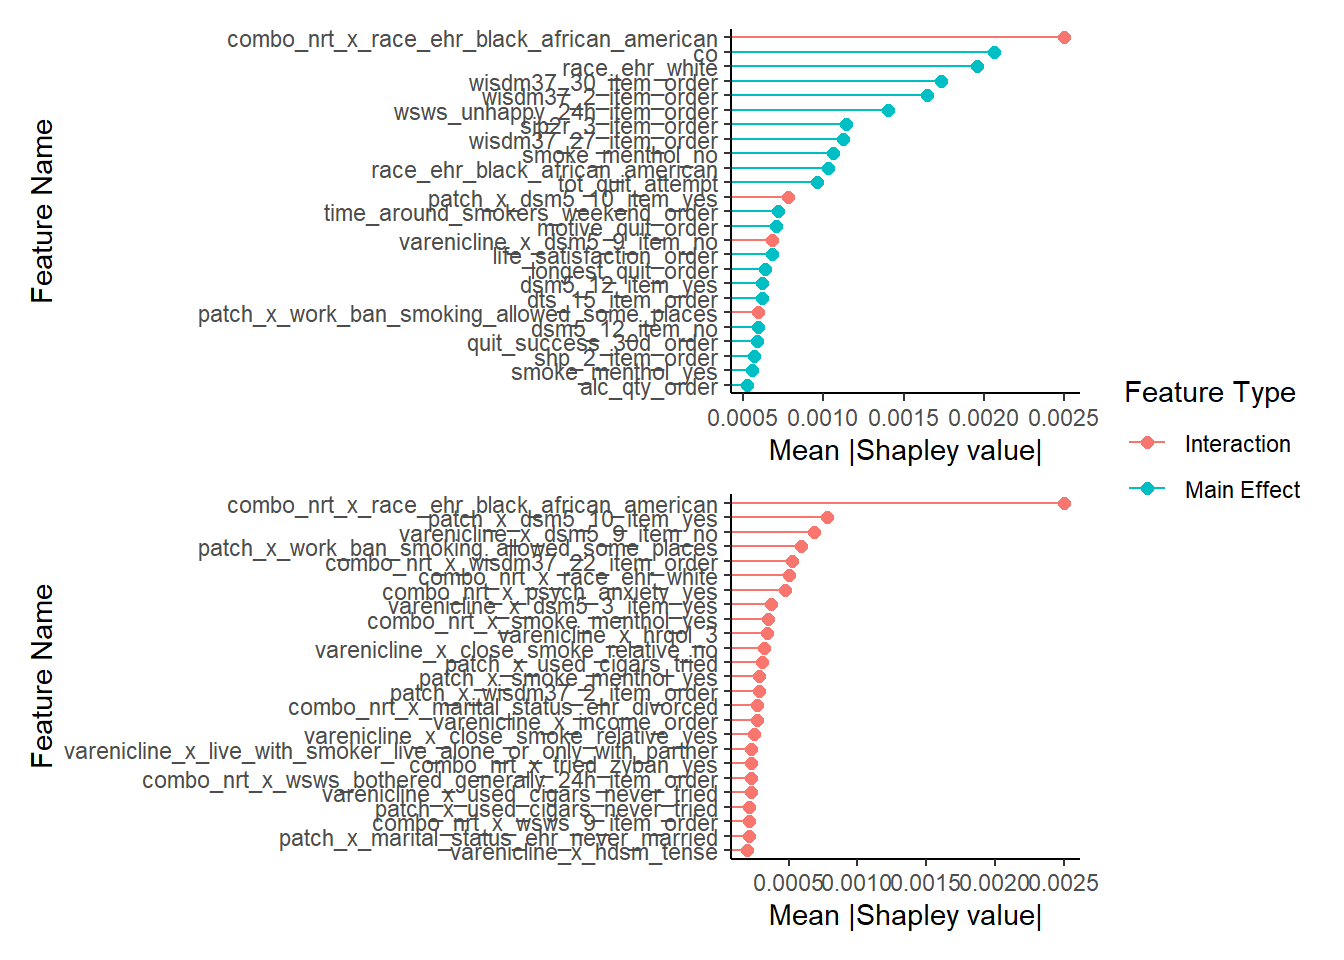

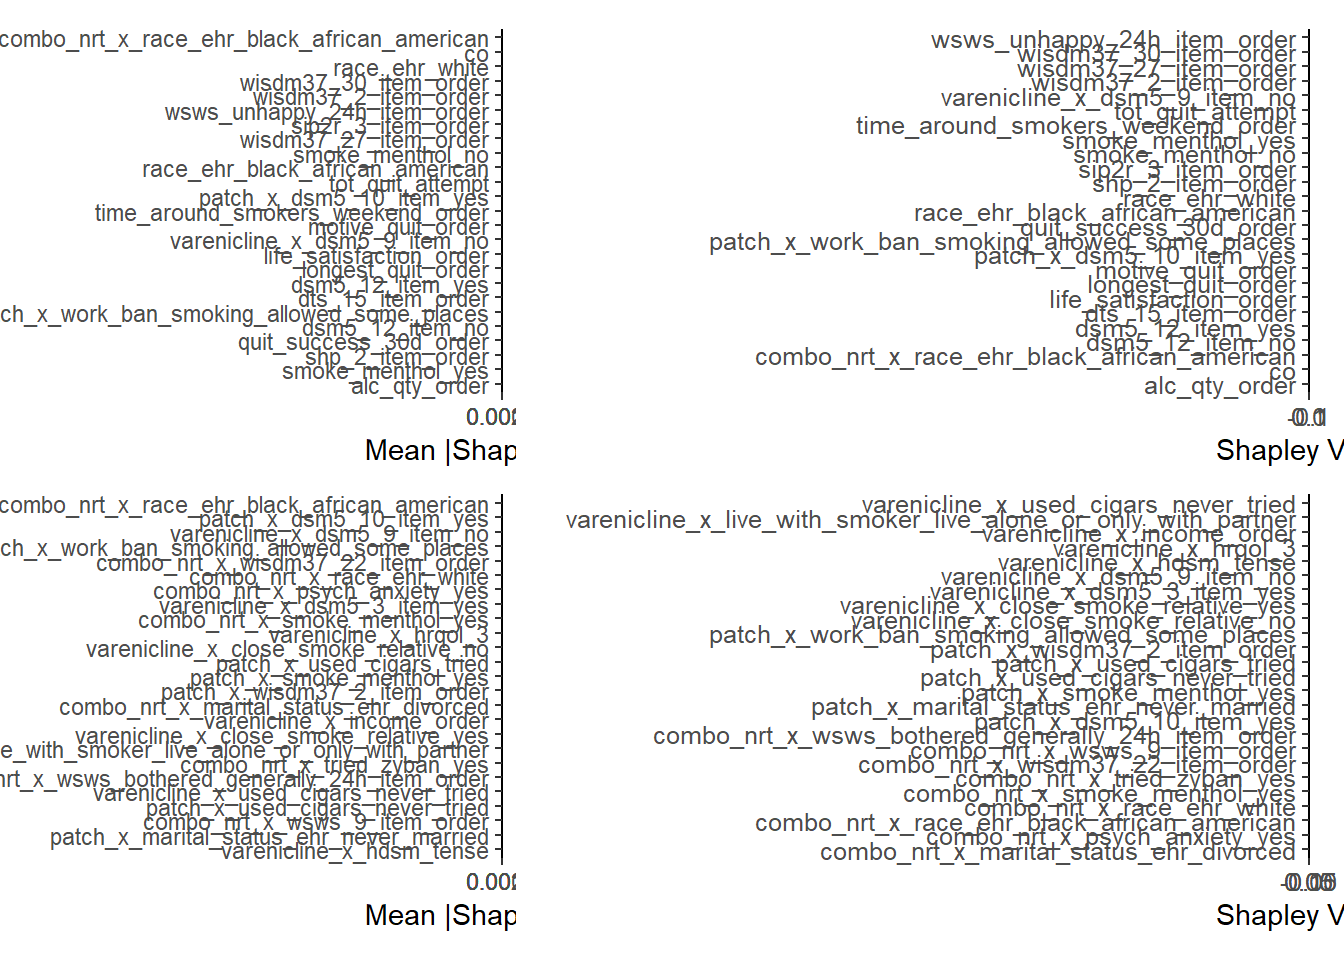

In [ ]:
library(patchwork)

(fig_shap_global / fig_shap_global_tx) +
  plot_layout(guides = "collect")